# Tutorial 

In [325]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.linalg import svdvals
from scipy.sparse import spdiags

from functools import partial

from deconvolution import (
    BlurringOperator,
    MixtureDistribution,
    toeplitz_structure,
    variable_projection_total_variation)


### Latent Signal 

Suppose the latent signal is provided by the function
$$x_{true}(t_i) = \begin{cases}
0,\quad -N\leq t_i<-N/6 \\
1,\quad -N/6 \leq t_i < N/6 \\ 
0,\quad N/6 \leq t_i \leq N
\end{cases}$$
where $x_{true}(t_i)$ is the intensity of each pixel $t_i$. 

Define the domain to be equally spaced points in some interval

In [326]:
def equispaced_points(number_of_points):
    """Returns an equally spaced array centered about zero
    with `number_of_points + 1` points."""
    return np.arange(
        -number_of_points // 2,
        number_of_points // 2 + 1,
        dtype=float)


Suppose the `number_of_points` is given to be $N$. The $N+1$ *equispaced points* may be determined by the formula $t_i = t_{i-1} + 1$ where $t_1 = -\lceil N / 2 \rceil$.

Why do we choose equally spaced points? 🤔

### Constructing the Domain

In [327]:
t = equispaced_points(number_of_points=128)  # returns 129 points total


### Constructing the latent signal

In [328]:
N = t.size
latent_signal = np.piecewise(
    t,
    [t < N/6, -N/6 <= t, N/6 <= t],
    [0, 1, 0])


### The Latent Signal

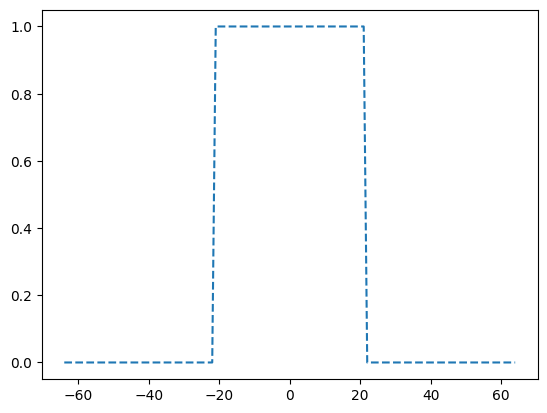

In [329]:
plt.plot(t, latent_signal, '--');


### Convolution 

$$ (f*g)(t) = \int_{-\infty}^{\infty}f(\tau)g(t-\tau)\tau'$$

The kernel is assumed to be a mixture distribution 

### Mixture Distribution

The mixture distribution $p$ is determined by weights and parameterized mixture components.

$$p(y)=\sum_{k=1}^nw_k p_k(\theta_k)$$

The distributions $p_k$ are the mixture components, $w_k$ denotes the mixture weights, and $\theta_k$
are the parameters for each component in the mixture. And $y=(w_1,\dots,w_n,\theta_1,\dots,\theta_n)$. 

In our case let each mixture component be a normal distribution. 

Then, 
$$ p(y) = \sum_{i=1}^n w_k f(t_i;\theta_k)$$
where
$$f(t_i;\theta_k)=Se^{-\frac{1}{2}(\frac{t_i-\mu_k}{\sigma_k})^2}$$
with $\theta_k = (\mu_k,\sigma_k)$ and $S_k$ being some constant such that $\sum_i f(t_i;\theta_k) = 1$.

### Normal Distribution

In [330]:
def normal_distribution(domain, mean, standard_deviation):
    t = domain
    mu = mean
    sigma = standard_deviation
    gaussian = np.exp(-0.5 * ((t - mu) / sigma)**2)
    normalization_constant = 1/sum(gaussian)
    return gaussian * normalization_constant


Given the function  

$$f(t_i; \mu, \sigma)=e^{-\frac{1}{2}(\frac{t_i-\mu}{\sigma})^2}$$

The sum $S=\sum_{i}f(t_i;\mu,\sigma)$ is not necessarily equal to one. The function 
$f$ is normailized by multiplying  $f(t_i;\mu,\sigma)$ by $S^{-1}$. 

Why do we normalize the function in this way? 🤔

### Derivatives

The derivative of the normal distribution with respect to the mean 

In [331]:
def derivative_wrt_mean(domain, mean, standard_deviation):
    t = domain
    mu = mean
    sigma = standard_deviation
    return np.exp(-(t-mu)**2 / (2*sigma**2)) * ((t-mu) / (sigma**2))


The derivative of the function $f$ with respect to the *mean* is provided by the equation

$$\frac{\partial f}{\partial \mu}=\frac{t_i-\mu}{\sigma^2}e^{-\frac{1}{2}(\frac{t_i-\mu}{\sigma})^2}$$

The derivative with respect to the standard deviation 

In [332]:
def derivative_wrt_standard_deviation(domain, mean, standard_deviation):
    t = domain
    mu = mean
    sigma = standard_deviation
    return np.exp(-(t-mu)**2 / (2*sigma**2)) * ((t-mu)**2) / (sigma**3)


The derivative with repect to the *standard deviation* is provided by 

$$\frac{\partial f}{\partial \mu} = \frac{(t_i-\mu)^2}{\sigma^2} e^{-\frac{1}{2}(\frac{t_i-\mu}{\sigma})^2}$$

### Parameters

First lets define the weights and the parameters of the mixture. 

In [333]:
weights = np.array([0.5, 0.5])  # mixture weights
means = np.array([0, 0])  # parameter
standard_deviations = np.array([10, 20])  # parameter


Stack the parameters into a single array

In [334]:
parameters = np.column_stack((means, standard_deviations))
print("Parameters are stacked:")
print(parameters)


Parameters are stacked:
[[ 0 10]
 [ 0 20]]


### Construct the mixture model

In [335]:
mixture_model = MixtureDistribution(
    domain=t,
    mixture_weights=weights,
    mixture_component_parameters=parameters,
    mixture_components=[normal_distribution for _ in parameters],
    mixture_component_derivatives=[
        derivative_wrt_mean, derivative_wrt_standard_deviation])


### The Mixture Model

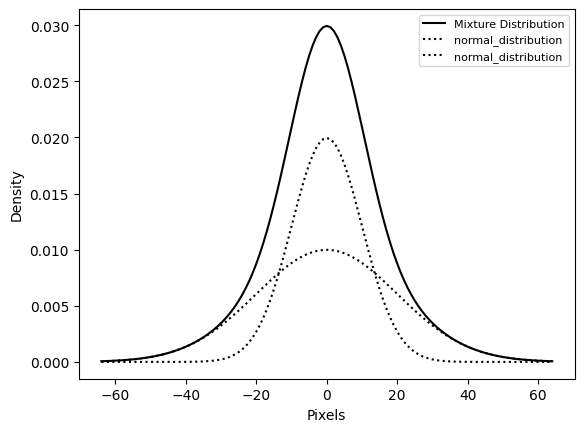

In [336]:
mixture_model.visualize_mixture()


### Construct the blurring operator

In [337]:
blur = BlurringOperator(mixture_model.array, toeplitz_structure)


### Noise 

Lets say the data contains some percentage of gaussian noise

In [338]:
def guassian_noise(percentage, latent_signal):
    np.random.seed(1) # Control randomness 
    mu = 0 # Mean 
    std = latent_signal.std() # Standard deviation
    N = latent_signal.size # number of points 
    random_noise = np.random.normal(loc=0, scale=std, size=N)
    return  random_noise * percentage


Say 5%

In [339]:
percentage = 0.05


Create the noise

In [340]:
noise = guassian_noise(percentage, latent_signal)


### Lets Plot the Noise

In [341]:
def visualize(t, noise):
    fig = plt.figure()
    gs = fig.add_gridspec(1,2, width_ratios=(4, 1), left=0.1, right=0.9, 
                      bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
    ax1 = fig.add_subplot(gs[0,0])
    ax1.grid(True)
    ax1.set_ylabel('Noise')
    ax1.set_xlabel('Per Pixel') 

    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax2.tick_params(axis="y", labelleft=False)
    ax2.set_xlabel('Count')

    ax1.plot(t, noise)
    ax2.hist(noise, 20, density=True, orientation='horizontal');

### The Noise

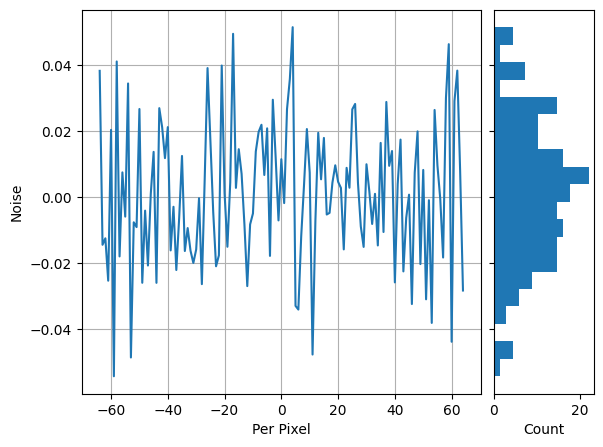

In [342]:
visualize(t, noise)

### The Data

In [343]:
data = blur @ latent_signal + noise

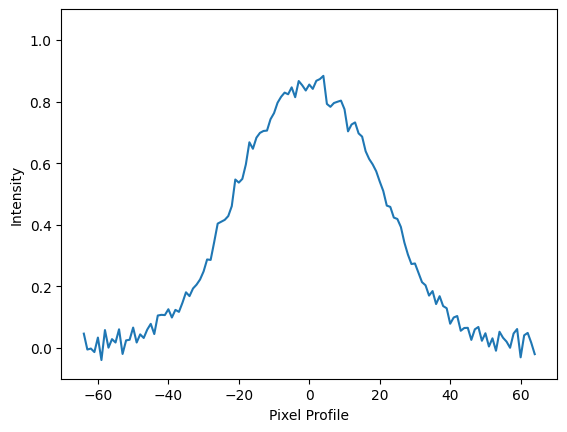

In [344]:
plt.plot(t, data)
plt.xlabel('Pixel Profile')
plt.ylabel('Intensity')
plt.ylim([-0.1, 1.1]);

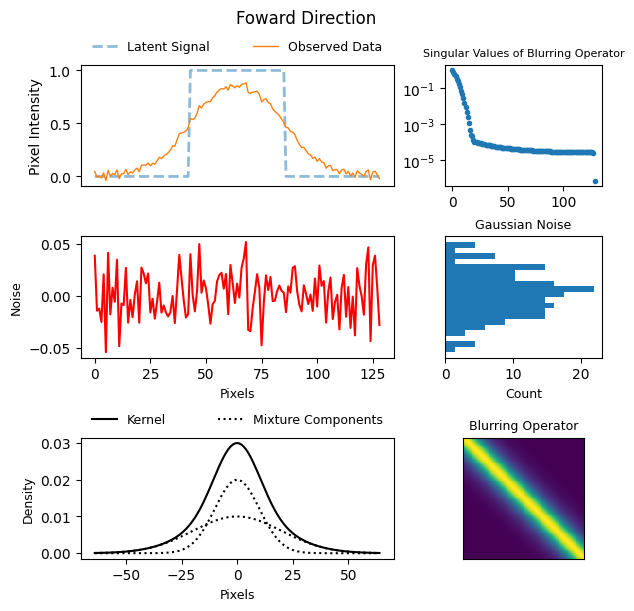

In [345]:
fig = plt.figure(layout="constrained", figsize=(6, 6))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[-1, :2])
ax3 = fig.add_subplot(gs[1, :-1])
ax4 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[-1, 2])

ax1.plot(t, latent_signal, '--', linewidth='2',
         alpha=0.5, label='Latent Signal')
ax1.plot(t, data, linewidth=1, label='Observed Data')
ax1.legend(bbox_to_anchor=(0, 1, 1, .1), ncol=2, mode='expand',
           loc='lower left', framealpha=0, fontsize=9)
ax1.set_ylabel('Pixel Intensity')
ax1.tick_params(bottom=False, labelbottom=False)

ax2.plot(t, mixture_model.array, 'k', label='Kernel')
ax2.plot(t, weights[0] * mixture_model.components_array[0],
         'k:', label='Mixture Components')
ax2.plot(t, weights[1] * mixture_model.components_array[1], 'k:')
ax2.set_ylabel('Density', fontsize=9)
ax2.set_xlabel('Pixels', fontsize=9)
ax2.legend(bbox_to_anchor=(0, 1, 1, .1), ncol=2, mode='expand',
           loc='lower left', framealpha=0, fontsize=9)

ax3.plot(noise, 'r', label='Noise')
ax3.set_xlabel('Pixels', fontsize=9)
ax3.set_ylabel('Noise', fontsize=9)

ax4.semilogy(svdvals(blur.matrix), '.')
ax4.set_title('Singular Values of Blurring Operator', fontsize=8)

count, bins, ignored = ax5.hist(
    noise, 20, density=True, orientation='horizontal')
ax5.tick_params(labelleft=False, left=False)
ax5.set_xlabel('Count', fontsize=9)
ax5.set_title('Gaussian Noise', fontsize=9)

ax6.matshow(blur.matrix)
ax6.set_title('Blurring Operator', fontsize=9)
ax6.tick_params(labeltop=False, labelleft=False,
                top=False, left=False, bottom=False)

fig.suptitle("Foward Direction")

plt.show()


### 

### Regularization Matrix

In [346]:
def total_variation(x):
    BETA = 1e-16
    ones = np.ones_like(x)
    D = spdiags([-ones, ones], diags=[0, 1]) # forward difference
    return np.diag(1/(((D*x)**2 + BETA**2)**(1/4))) @ D


### Jacobian

In [347]:
def rjf_jacobian(signal, partial_derivatives, structure):
    result = []
    for derivative in partial_derivatives:
        matrix = structure(derivative, derivative.size // 2)
        result.append(matrix @ signal)
    return np.array(result).T


### Construct the Mixture Model

In [348]:
mixture_model = variable_projection_total_variation(
    data,
    initial_signal=latent_signal,
    initial_mixture_model=mixture_model,
    blur_structure=partial(toeplitz_structure),
    jacobian=rjf_jacobian,
    regularization_parameter=0.1,
    regularization_matrix=total_variation,
    max_iterations=10,
    tolerance=1)


### The Mixture Model

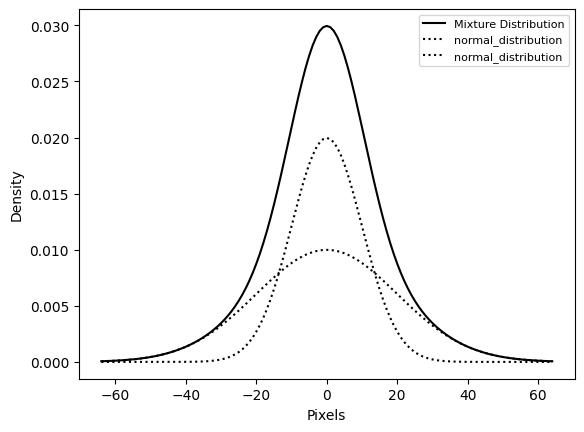

In [349]:
mixture_model.visualize_mixture()


In [350]:
!jupyter nbconvert 'example.ipynb' --to slides --post serve

[NbConvertApp] Converting notebook example.ipynb to slides
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 556947 bytes to example.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/example.slides.html
Use Control-C to stop this server


^C

Interrupted
